# Plotting geometries

[Geometries](https://developers.arcgis.com/geoanalytics/core-concepts/geometry/) in ArcGIS GeoAnalytics Engine consist of points, lines, polygons and multipoints. Plotting geometries can help you visualize the shapres and better understand the spatial data you are working with. This notebook will introduce you to some of the ways you can use the plotting functionality that is built-in with ArcGIS GeoAnalytics Engine.

At the end of the notebook, you'll produce a plot like the one below using the plotting functionality in ArcGIS GeoAnalytics Engine.

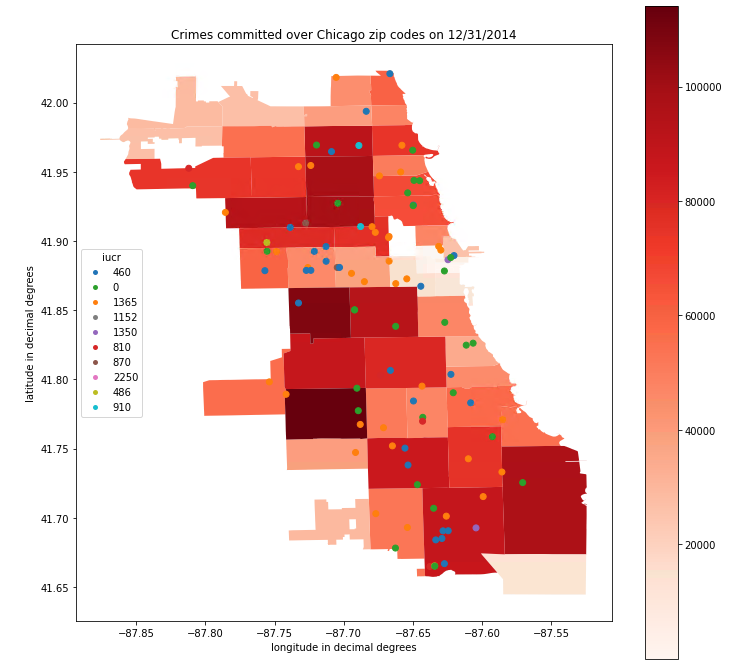

### Workflow overview
1. Plot [point data](#point-data)
2. Use matplotlib.pyplot [variable-length](#variable-length) arguments.
3. Use matplotlib.cm [colormaps](#colormaps) for categorical and continuous.
4. Plot [line data](#line-data)
5. Plot [unknown-data](#unknown-data)
6. Plot multiple axes on the [same figure](#same-figure).
7. Plot [polygon data](#polygon-data)
8. [Crimes Example](#crimes-example)

In [1]:
import geoanalytics
from geoanalytics.sql import functions as ST, Point
from pyspark.sql import functions as F
geoanalytics.auth(username="username",password="password")

## Plot point data <a name="point-data" />

In [2]:
# Create a DataFrame with point data
points_wkt = [(0, Point(0, 0), "blue"), 
              (1, Point(0, 5), "red"), 
              (2, Point(5, 5), "green"), 
              (3, Point(5, 0), "blue"), 
              (4, Point(2.5, 2.5), "yellow")
             ]

points_df = spark.createDataFrame(points_wkt, ["id", "point", "color"])
points_df.show(truncate=False)

+---+-----------------+------+
|id |point            |color |
+---+-----------------+------+
|0  |{"x":0,"y":0}    |blue  |
|1  |{"x":0,"y":5}    |red   |
|2  |{"x":5,"y":5}    |green |
|3  |{"x":5,"y":0}    |blue  |
|4  |{"x":2.5,"y":2.5}|yellow|
+---+-----------------+------+



Calling `df.st.plot()` will plot the geometries in the DataFrame given that the column containing the geometries is named "geometry". If you would like to specify a specific column to plot, call `df.st.plot(geometry=["GEOM_COLUMN_NAME"]`

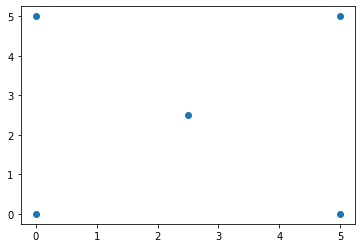

In [3]:
points_df.st.plot();

The `plot()` function leverages matplotlib.pyplot and is passed similar arguments to customize the plotted figure. Here is an example of the how to control the aspect, markersize, marker and color of the plot above. A full list of possible values for `plot()`'s variable-length arguments can be found in [matplotlib's documentation](https://matplotlib.org/stable/api/).

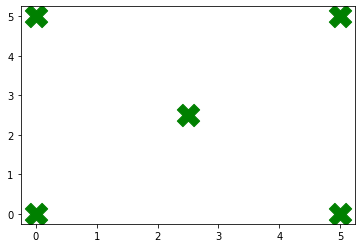

In [4]:
points_df.st.plot(aspect="auto", s=500, marker="X", color="green");

Commonly, you'll want to plot data color-coded by a specific attribute. This is known as a "color mapping". The attribute may either be continuous or categorical. One way to plot data based on a category is to manually assign a specific color for every category and pass this column to the cmap_values argument. <a name="variable-length" />

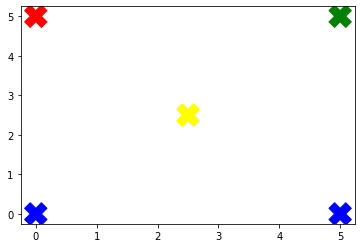

In [5]:
ax = points_df.st.plot(cmap_values="color", aspect="auto", s=500, marker="X")

A better way is to let matplotlib's built-in [colormapping](https://matplotlib.org/stable/tutorials/colors/colormaps.html) do this for you. First, create a DataFrame with a multipoint geometry column and a category column. Matplotlib's cmap can handle both categorical data and continuous data. 
- For categorical data, cmap needs it to be encoded in numerical form in order to apply the colormapping. To encode the categorical data, add the id column which has a one-to-one mapping with the category column. To distinguish between categorical mapping and continuous mapping select a colormap that has qualitative colors and pass discrete values to the cmap_values. 
- To map continuous data, pass continuous values to the cmap_values and choose a colormapping that is sequential. <a name="colormaps" />

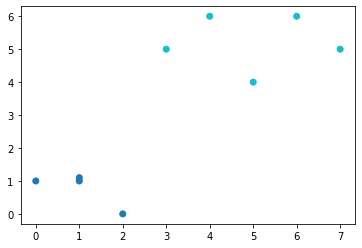

In [6]:
# Color mapping categorical data
mpoints_wkt = [(0, "MULTIPOINT(0 1, 1 1, 1 1.1, 2 0)", "A"), (1, "MULTIPOINT(5 4, 4 6, 7 5, 3 5, 6 6)", "B")]
mpoints = spark.createDataFrame(mpoints_wkt).toDF("id", "wkt", "category")\
    .withColumn("geometry", ST.mpoint_from_text("wkt")).drop("wkt")
mpoints.st.plot(cmap="tab10", cmap_values="id");

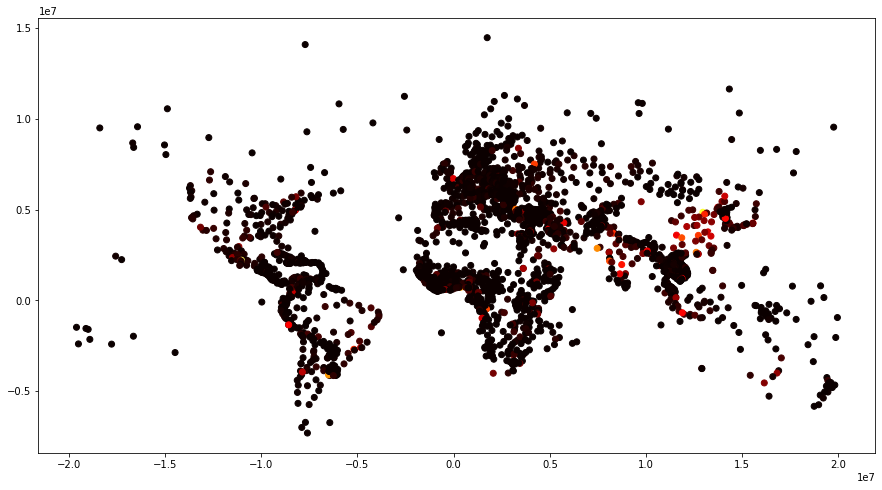

In [7]:
# Color mapping continuous data (world city populations)
cities_FS ="https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/World_Cities/FeatureServer/0"
cities = spark.read.format('feature-service').load(cities_FS)
cities.st.plot(figsize=(15,8), cmap_values="POP", cmap="hot", aspect="auto");

## Plot lines<a name="line-data" />
ArcGIS GeoAnalytics Engine can plot more than just points. Here is an example of how to plot linestrings and set the edgecolor. 

+---+-------------------------------------------+
|id |geometry                                   |
+---+-------------------------------------------+
|0  |{"paths":[[[1,5],[0,5],[0,4],[1,4]]]}      |
|1  |{"paths":[[[2,4],[2,5],[3,5],[3,4],[2,4]]]}|
|2  |{"paths":[[[4,4],[4,5],[5,5],[5,4],[4,4]]]}|
|1  |{"paths":[[[6,5],[6,4],[7,4]]]}            |
+---+-------------------------------------------+



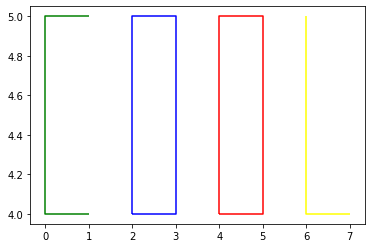

In [8]:
lines_wkt = [(0, "LINESTRING (1 5, 0 5, 0 4, 1 4)"), 
             (1, "LINESTRING (2 4, 2 5, 3 5, 3 4, 2 4)"), 
             (2, "LINESTRING (4 4, 4 5, 5 5, 5 4, 4 4)"), 
             (1, "LINESTRING (6 5, 6 4, 7 4)")]
lines_wkt_df = spark.createDataFrame(lines_wkt).toDF("id", "wkt")
lines_df = lines_wkt_df.withColumn("geometry", ST.line_from_text("wkt")).select("id", "geometry").cache()

lines_df.show(truncate=False)
lines_df.st.plot(edgecolor=["green", "blue", "red", "yellow"]);

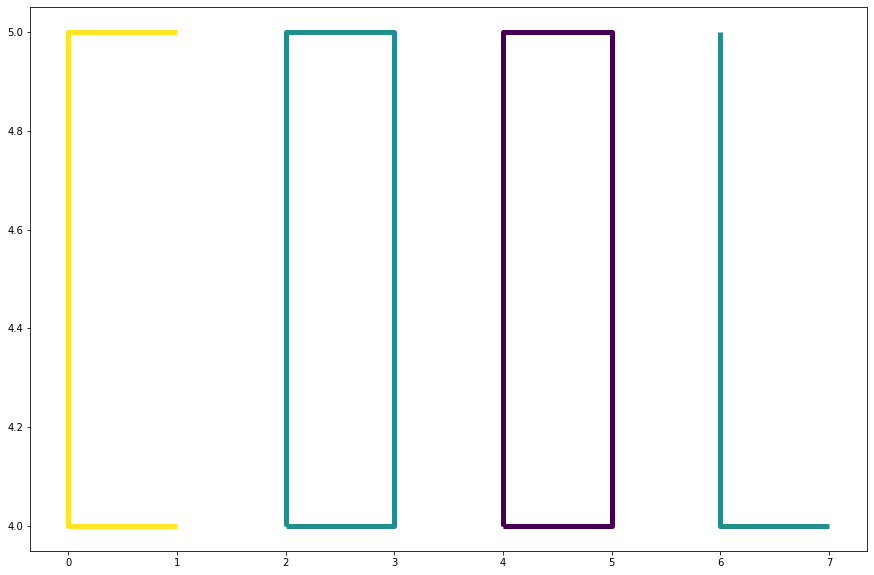

In [9]:
# Use the id column for discrete color mapping, setting figsize and linewidth
lines_df.st.plot(cmap_values="id", cmap="viridis_r", figsize=(15,10), linewidth=5);

## Plot columns of more than one geometry type <a name="unknown-data" />
ArcGIS GeoAnalytics Engine can also plot geometries of different types in the same plot. For example, polygons and points. Note how manually assigning the color applies to all geometries in the plot. 

In [10]:
unk_points_df = points_df.withColumn("mixed_geometry", ST.cast("point", "geometry")).select("mixed_geometry")
unk_lines_df = lines_df.withColumn("mixed_geometry", ST.cast("geometry", "geometry")).select("mixed_geometry")
geometries_df = unk_points_df.union(unk_lines_df)

geometries_df.printSchema()
geometries_df.show(truncate=False)

root
 |-- mixed_geometry: geometry (nullable = true)

+-------------------------------------------+
|mixed_geometry                             |
+-------------------------------------------+
|{"x":0,"y":0}                              |
|{"x":0,"y":5}                              |
|{"x":5,"y":5}                              |
|{"x":5,"y":0}                              |
|{"x":2.5,"y":2.5}                          |
|{"paths":[[[1,5],[0,5],[0,4],[1,4]]]}      |
|{"paths":[[[2,4],[2,5],[3,5],[3,4],[2,4]]]}|
|{"paths":[[[4,4],[4,5],[5,5],[5,4],[4,4]]]}|
|{"paths":[[[6,5],[6,4],[7,4]]]}            |
+-------------------------------------------+



<AxesSubplot:>

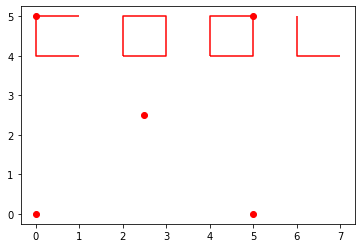

In [11]:
# Plot linestrings and points together
geometries_df.st.plot(color="red")

ArcGIS GeoAnalytics Engine plots return the matploblib axes. You can pass these axes to another plot to overlay different geometry columns in the same plot. <a name="same-figure" /> There's a lot you can do with the [axes](https://matplotlib.org/stable/api/axes_api.html), such as setting the title and x and y labels. Note: Adding a semicolon to the last axes expression prevents matplotlib descriptions from displaying in Jupyter Notebooks.

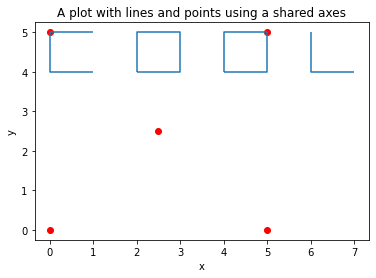

In [12]:
# Example using the axes argument
lines_ax = lines_df.st.plot()
points_ax = points_df.st.plot(ax=lines_ax, color="red")
points_ax.set_xlabel("x")
points_ax.set_ylabel("y")
points_ax.set_title("A plot with lines and points using a shared axes");

## Plot polygons <a name="polygon-data" />

+--------------------------------------------------------------------------------------------------------------------------------+------+
|geometry                                                                                                                        |values|
+--------------------------------------------------------------------------------------------------------------------------------+------+
|{"rings":[[[0,0],[0,10],[10,10],[10,0],[0,0]]]}                                                                                 |0     |
|{"rings":[[[40,40],[45,30],[20,45],[40,40]],[[20,35],[45,20],[30,5],[10,10],[10,30],[20,35]],[[30,20],[20,25],[20,15],[30,20]]]}|3     |
+--------------------------------------------------------------------------------------------------------------------------------+------+



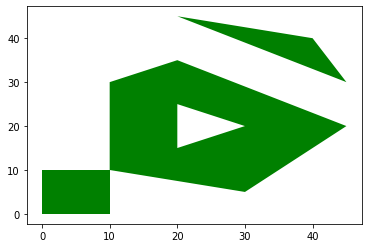

In [13]:
# Plot polygons example
poly_wkt = [
    (0, "POLYGON ((0 0, 0 10, 10 10, 10 0, 0 0))"),
    (3, "MULTIPOLYGON (((40 40, 20 45, 45 30, 40 40)),((20 35, 10 30, 10 10, 30 5, 45 20, 20 35),(30 20, 20 15, 20 25, 30 20)))")
]

poly_wkt_df = spark.createDataFrame(poly_wkt).toDF("values", "wkt")
poly_df = poly_wkt_df.withColumn("geometry", ST.poly_from_text("wkt")).select("geometry","values").cache()
poly_df.show(truncate=False)
poly_df.st.plot(facecolors="green");

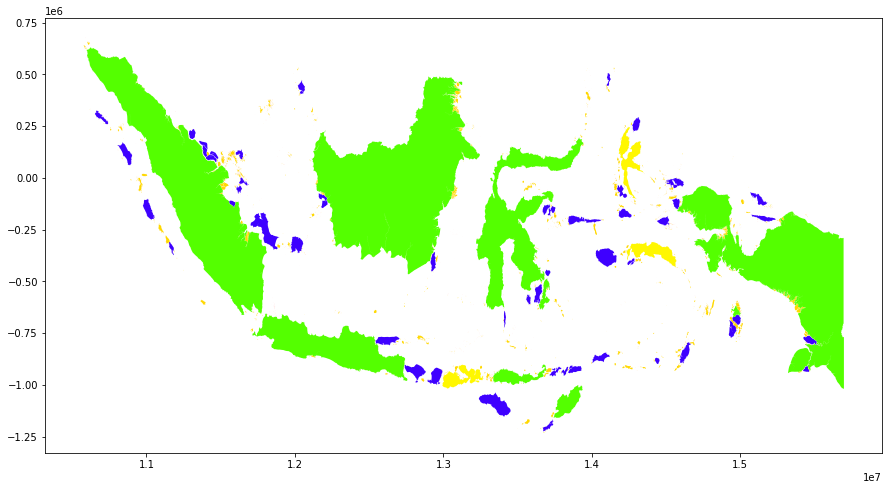

In [14]:
# Example of plotting world countries, filtering by country and coloring by land area
countries_FS ="https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/World_Countries/FeatureServer/0"
countries = spark.read.format('feature-service').load(countries_FS)

countries.where(F.col("COUNTRY") == "Indonesia").st.plot(cmap_values="Shape__Area", cmap="prism", figsize=(15,8));

Below, the plotting functionality is used to visualize the type of crimes committed in Chicago zip codes areas.<a name="crimes-example" />

In [15]:
# You can find this dataset here: \\qalab_server\pyunit\ArcGISOnline\GeoAnalyticsOnDemandEngine-samples\ChicagoZipCodes
# TODO: Upload and update the data
zips = spark.read.format("shapefile").load("C:/git/pysparkTestHarness/pysparkTestHarness/data/shapefile/ChicagoZipCodes")
zips.show(4)

+--------+-------------+-----+---------------+--------------------+
|objectid|    shape_len|  zip|     shape_area|            geometry|
+--------+-------------+-----+---------------+--------------------+
|    33.0|42720.0444058|60647|1.06052287488E8|{"rings":[[[-87.6...|
|    34.0|48103.7827213|60639|1.27476050762E8|{"rings":[[[-87.7...|
|    35.0|27288.6096123|60707|4.50690384783E7|{"rings":[[[-87.7...|
|    36.0|42527.9896789|60622|7.08538343797E7|{"rings":[[[-87.6...|
+--------+-------------+-----+---------------+--------------------+
only showing top 4 rows



In [16]:
# CSV originally from here: https://worldpopulationreview.com/zips/illinois
# TODO: Upload and update the data
# Located here: TODO: \\qalab_server\pyunit\ArcGISOnline\GeoAnalyticsOnDemandEngine-samples\ChicagoPopulation\ChicagoPopulation.csv
population_df = spark.read.option("header","true").csv("C:/Users/sara7668/Downloads/csvData.csv")
population_df.show(5)

+-----+-------+------+------+
|  zip|   city|county|   pop|
+-----+-------+------+------+
|60629|Chicago|  Cook|110029|
|60618|Chicago|  Cook| 94907|
|60632|Chicago|  Cook| 89857|
|60639|Chicago|  Cook| 88204|
|60647|Chicago|  Cook| 87633|
+-----+-------+------+------+
only showing top 5 rows



In [17]:
# Join zip codes with population by zip code 
zipsWithPop = zips.join(population_df, zips["zip"]==population_df["zip"]).withColumn("pop", F.col("pop").cast("double"))
zipsWithPop.show(5)

+--------+-------------+-----+---------------+--------------------+-----+------------+------+-------+
|objectid|    shape_len|  zip|     shape_area|            geometry|  zip|        city|county|    pop|
+--------+-------------+-----+---------------+--------------------+-----+------------+------+-------+
|    33.0|42720.0444058|60647|1.06052287488E8|{"rings":[[[-87.6...|60647|     Chicago|  Cook|87633.0|
|    34.0|48103.7827213|60639|1.27476050762E8|{"rings":[[[-87.7...|60639|     Chicago|  Cook|88204.0|
|    35.0|27288.6096123|60707|4.50690384783E7|{"rings":[[[-87.7...|60707|Elmwood Park|  Cook|43093.0|
|    36.0|42527.9896789|60622|7.08538343797E7|{"rings":[[[-87.6...|60622|     Chicago|  Cook|53294.0|
|    37.0|47970.1401531|60651|9.90396212518E7|{"rings":[[[-87.7...|60651|     Chicago|  Cook|63492.0|
+--------+-------------+-----+---------------+--------------------+-----+------------+------+-------+
only showing top 5 rows



Visualize the chicago zip code borders as polygons. Plot the crimes dataset (points) with the zip codes (polygons). These crimes occured on 12/31/2014.

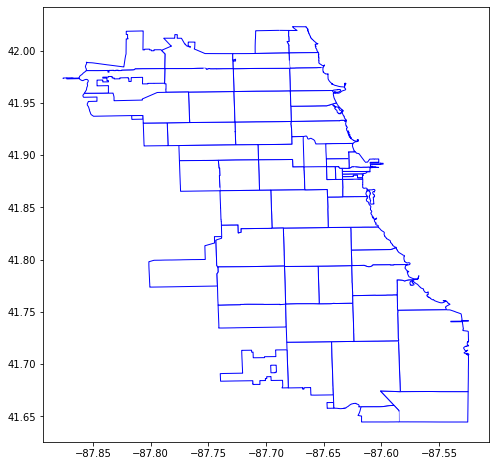

In [18]:
# Visualize Chicago zip code borders as polygons
zipsWithPop.st.plot(figsize=(8,8), facecolor="white", edgecolor="blue");

The crimes dataset contains points representing the location of where the crime was committed and its corresponding Illinois Uniform Crime Reporting [IUCR](https://data.cityofchicago.org/widgets/c7ck-438e) code. This will serve as categorical input to our colormap.

In [19]:
# Data here: \\qalab_server\pyunit\ArcGISOnline\GeoAnalyticsOnDemandEngine-samples\ChicagoCrimes_subset
# TODO: Upload data
crimes = spark.read.format("shapefile").load("C:/git/pysparkTestHarness/pysparkTestHarness/data/shapefile/ChicagoCrimes_subset/")
crimes.select("ID", "geometry", "IUCR").show(4)

+-------+--------------------+----+
|     ID|            geometry|IUCR|
+-------+--------------------+----+
|9911557|{"x":905726.93574...| 460|
|9911147|{"x":908837.15595...|   0|
|9911122|{"x":902940.07954...|   0|
|9911062|{"x":912273.57698...|1365|
+-------+--------------------+----+
only showing top 4 rows



It is important to make sure all the DataFrames being plotted in the same plot have the same spatial reference. If they don't, transform the data to the same spatial reference before plotting. 

In [20]:
# Check the spatial reference of all DataFrames that are being plotted to make sure they are the same
print(crimes.st.get_spatial_reference())
print(zipsWithPop.st.get_spatial_reference())

SpatialReference(srid=26972, is_projected=True, unit='Meter')
SpatialReference(srid=0, is_projected=False, unit=None)


In [21]:
# Transform data to the same spatial reference for plotting
crimePoints = crimes.select(ST.transform("geometry", 4326).alias("geometry"), "IUCR")

Visualizing the crimes colored by IUCR. You can see that this information is less useful without the geographical context of the zipcode polygons. 

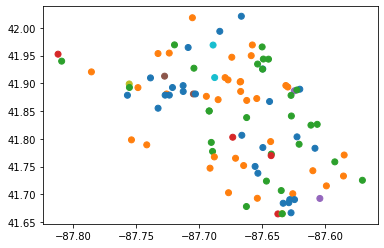

In [22]:
crimePoints.st.plot(cmap='tab10', cmap_values="IUCR");

To put it all together, plot the crimes colored by type on the zip codes polygons which are colored by increasing population size. 

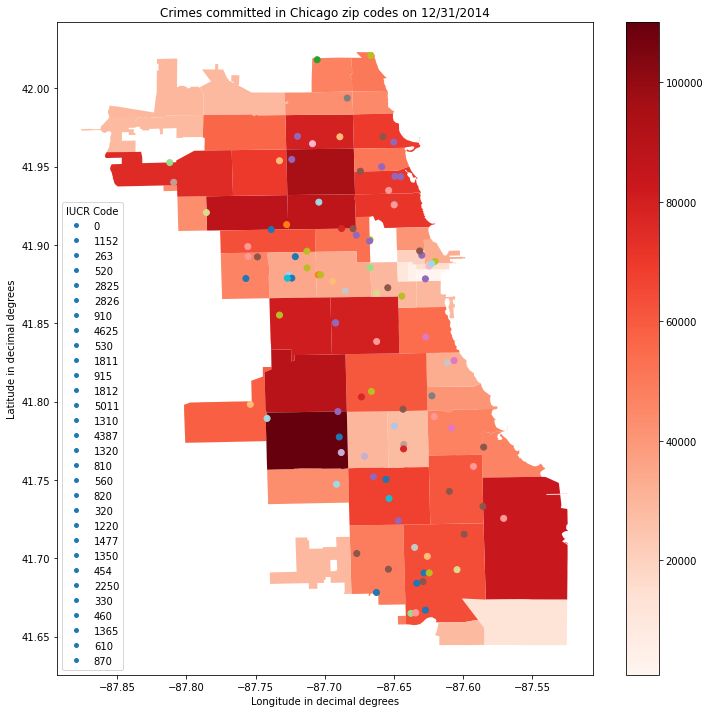

In [23]:
# Plot the zip codes and crimes together
zips_ax = zipsWithPop.st.plot(cmap_values="pop", cmap="Reds", figsize=(12,12), legend=True)
crime = crimePoints.st.plot(ax=zips_ax, 
                            cmap='tab20', 
                            cmap_values="IUCR", 
                            legend=True, 
                            is_categorical=True, 
                            legend_kwds={"loc": "lower left", "title":"IUCR Code"})
crime.set_ylabel("Latitude in decimal degrees")
crime.set_xlabel("Longitude in decimal degrees")
crime.set_title("Crimes committed in Chicago zip codes on 12/31/2014");
#TODO: New jar to fix the legend

In summary, this notebook shows you how to plot different geometry types, and some plotting parameters. You can learn more about plotting in the following tutorials and topics:

 - [Visualize results](https://next.sites.afd.arcgis.com/geoanalytics/core-concepts/visualize-results/)
 - [Visualize results with st.plot()](https://next.sites.afd.arcgis.com/geoanalytics/tutorials/visualize/visualize-results-st-plot/)
  